## 1. Consolidated files in the unique DataFrame and show the total files extracted

In [1]:
import os
import sys
import pandas as pd
from etl.common.utils.common import DefaultOutputFolder as dir

notebook_path = os.path.dirname(os.path.abspath("data_explorer.ipynb"))
sys.path.append(os.path.dirname(notebook_path))

## Files from Default Folder
files = os.listdir(dir())
dfs = []


if not files: print("No files found in the output folder.")

for file in files:
    if file.endswith(".parquet"):
        df = pd.read_parquet(dir() + file)
        dfs.append(df)
    
allFiles = pd.concat(dfs, ignore_index=True)

# Ordering DataFrame by column name
allFiles = allFiles.sort_values(by=['extracted_at'], ascending=False)

# count the rows in the all dataframe
allFiles.shape[0]

2458

## 1.1 Data set sample, list 5 files

In [2]:
allFiles.head(3)

,code,codein,name,high,low,varBid,pctChange,bid,ask,timestamp,create_date,symbol,extracted_at
2328,EUR,LAK,Euro/Kip Laosiano,23206,23206,0,0,22956,23456,1716350342,2024-05-22 00:59:02,EUR-LAK,2024-05-22 03:59:14
1480,USD,BBD,Dólar Americano/Dólar de Barbados,2.0209,2.0195,0.0007,0.03,1.9742,2.0663,1716350227,2024-05-22 00:57:07,USD-BBD,2024-05-22 03:57:23
1302,LTC,EUR,Litecoin/Euro,82.12,79,0.28,0.35,80.19,80.19,1716350123,2024-05-22 00:55:23,LTC-EUR,2024-05-22 03:56:27


## 2. Change DataTypes and Reorder columns

In [3]:
# Change data types
df = allFiles.astype({'ask': float, 'bid': float, 'varBid': float, 'pctChange': float})

# Show the dataframe
df.head(3)


,code,codein,name,high,low,varBid,pctChange,bid,ask,timestamp,create_date,symbol,extracted_at
2328,EUR,LAK,Euro/Kip Laosiano,23206,23206,0.0000,0.00,22956.0000,23456.0000,1716350342,2024-05-22 00:59:02,EUR-LAK,2024-05-22 03:59:14
1480,USD,BBD,Dólar Americano/Dólar de Barbados,2.0209,2.0195,0.0007,0.03,1.9742,2.0663,1716350227,2024-05-22 00:57:07,USD-BBD,2024-05-22 03:57:23
1302,LTC,EUR,Litecoin/Euro,82.12,79,0.2800,0.35,80.1900,80.1900,1716350123,2024-05-22 00:55:23,LTC-EUR,2024-05-22 03:56:27


## 3. Using SQL for Data Exploration
    3.1 What is the currency with the highest ask value?

In [4]:
from pandasql import sqldf

query = """
    SELECT symbol, name, max(ask) max_ask FROM df 
    where code = 'BRL' 
    group by symbol, name
    order by 3 desc limit 1
"""

newDf = sqldf(query, locals())

newDf



,symbol,name,max_ask
0,BRL-LBP,Real Brasileiro/Libra Libanesa,17491.5


    3.1 Disponible Data

In [5]:
from pandasql import sqldf

query = """
    SELECT * FROM df 
    order by extracted_at desc limit 5
"""

newDf = sqldf(query, locals())
 
newDf

,code,codein,name,high,low,varBid,pctChange,bid,ask,timestamp,create_date,symbol,extracted_at
0,EUR,LAK,Euro/Kip Laosiano,23206,23206,0.0000,0.00,22956.0000,23456.0000,1716350342,2024-05-22 00:59:02,EUR-LAK,2024-05-22 03:59:14
1,USD,BBD,Dólar Americano/Dólar de Barbados,2.0209,2.0195,0.0007,0.03,1.9742,2.0663,1716350227,2024-05-22 00:57:07,USD-BBD,2024-05-22 03:57:23
2,LTC,EUR,Litecoin/Euro,82.12,79,0.2800,0.35,80.1900,80.1900,1716350123,2024-05-22 00:55:23,LTC-EUR,2024-05-22 03:56:27
3,ETH,EUR,Ethereum/Euro,29.089,29.089,-0.1800,-0.61,28.8280,28.8660,1716350186,2024-05-22 00:56:26,ETH-EUR,2024-05-22 03:56:27
4,BRL,CNY,Real Brasileiro/Yuan Chinês,1.4131,1.4123,0.0004,0.03,1.4130,1.4133,1716350180,2024-05-22 00:56:20,BRL-CNY,2024-05-22 03:56:24


## 4. Using SQL + Matplotlib for Data Viz
    4.1 What is the TOP 10 Most Value Currency considering BRL?

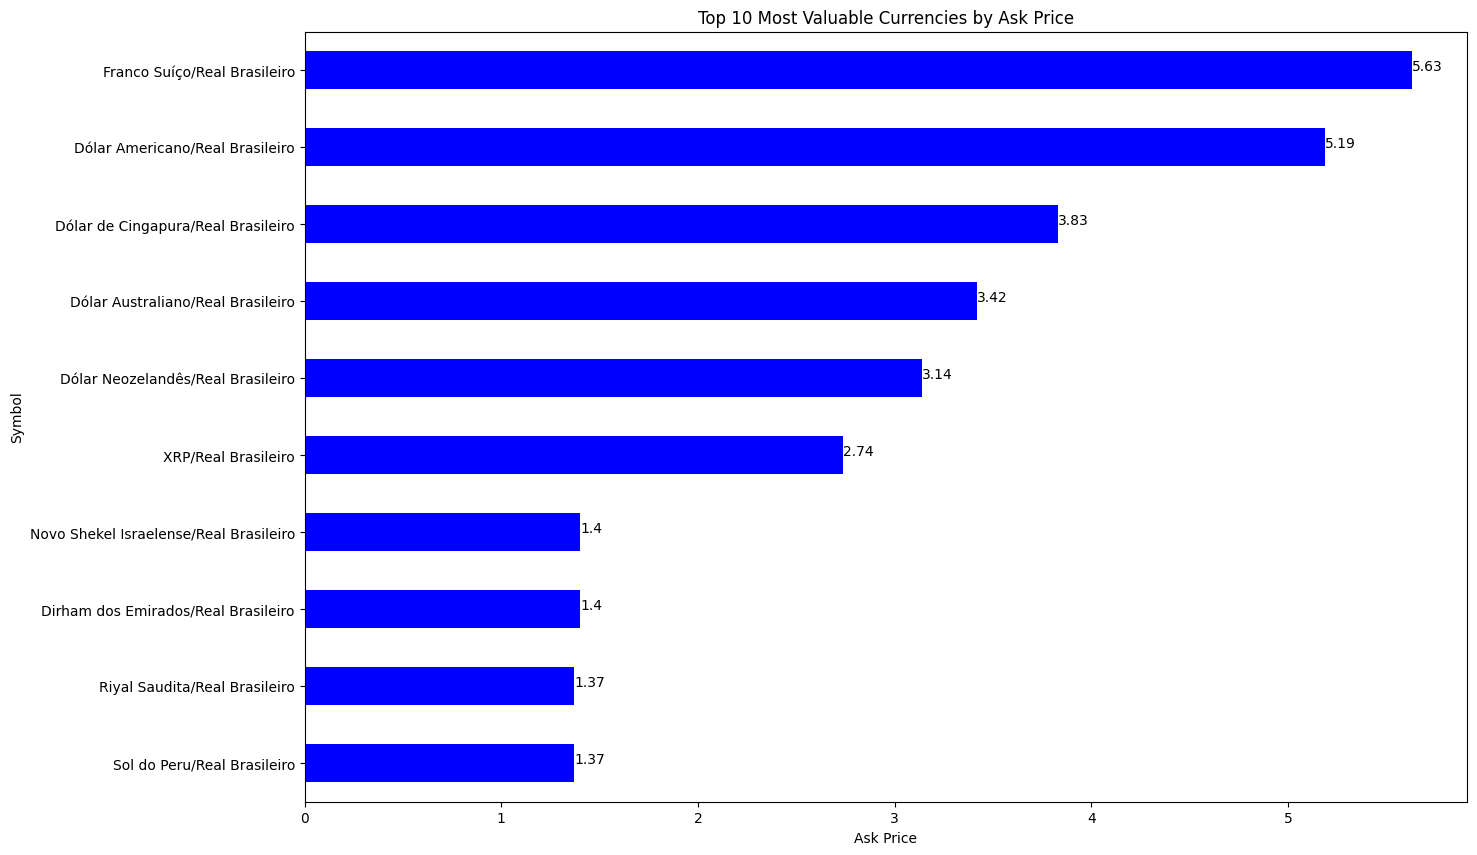

In [6]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        name
        ,round(avg(ask),2) AvgAsk
    FROM df 
    where codein = 'BRL'
    and not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    group by name
    order by avg(ask) desc limit 10
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='AvgAsk', ascending=True, inplace=True)

AvgAskByCurrency = newDf.plot(
    kind='barh', x='name', y='AvgAsk', 
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Top 10 Most Valuable Currencies by Ask Price', xlabel='Ask Price', ylabel='Symbol')


# Adicionando rótulos aos dados
for index, value in enumerate(newDf['AvgAsk']):
    plt.text(value, index, str(value))

# Exibir o gráfico
plt.show()

4.2 What is the TOP 10 locations BRL has + value?

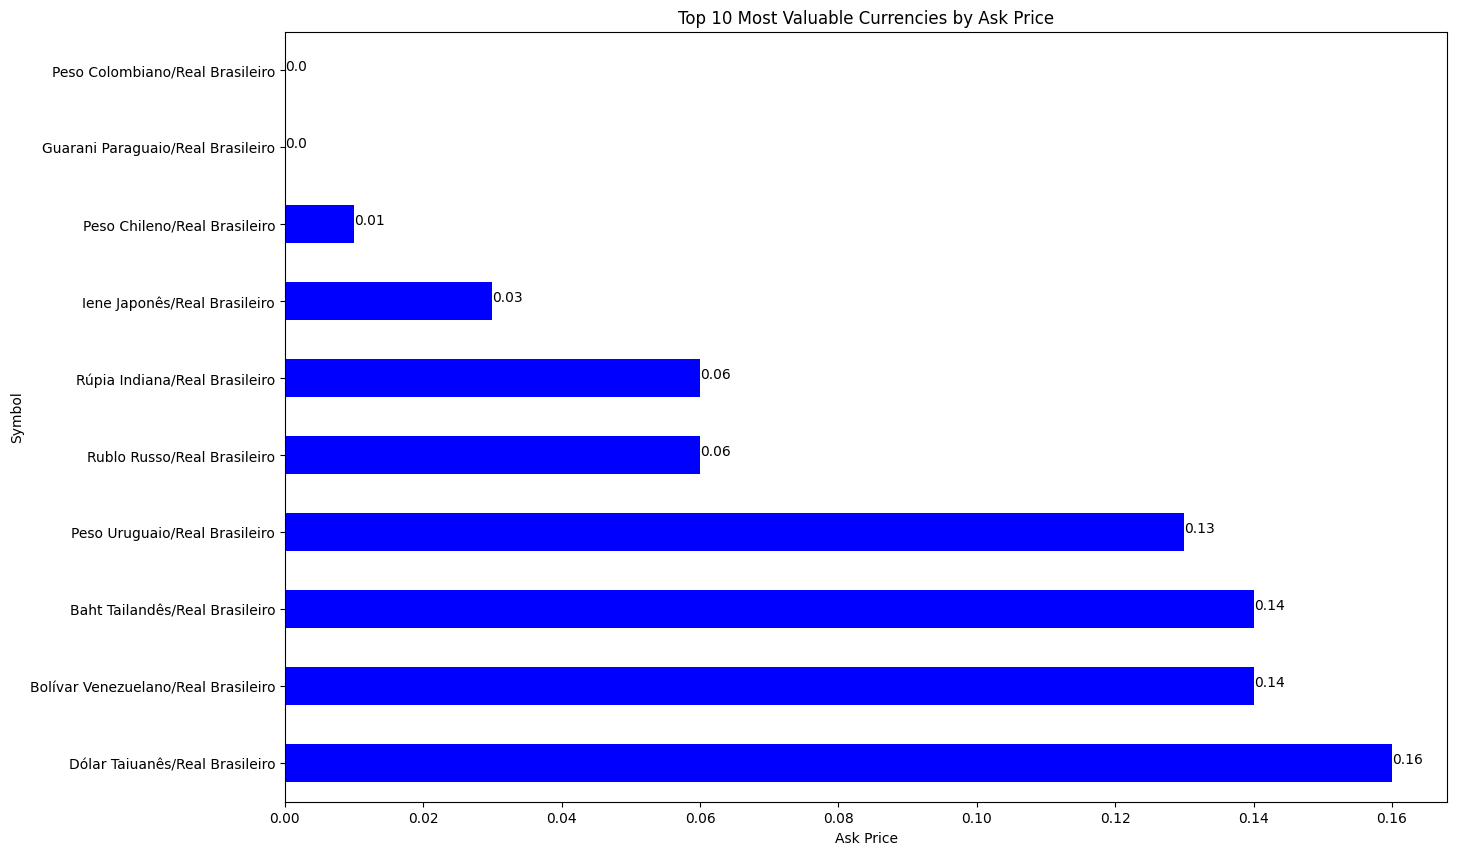

In [7]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        name
        ,round(avg(ask),2) AvgAsk
    FROM df 
    where codein = 'BRL'
    and not code in ('BTC', 'ETH', 'LTC')
    group by name
    order by avg(ask) limit 10
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='AvgAsk', ascending=False, inplace=True)

AvgAskByCurrency = newDf.plot(
    kind='barh', x='name', y='AvgAsk', 
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Top 10 Most Valuable Currencies by Ask Price', xlabel='Ask Price', ylabel='Symbol')


# Adicionando rótulos aos dados
for index, value in enumerate(newDf['AvgAsk']):
    plt.text(value, index, str(value))

# Exibir o gráfico
plt.show()

4.3 What the top 10 like BRL in value?

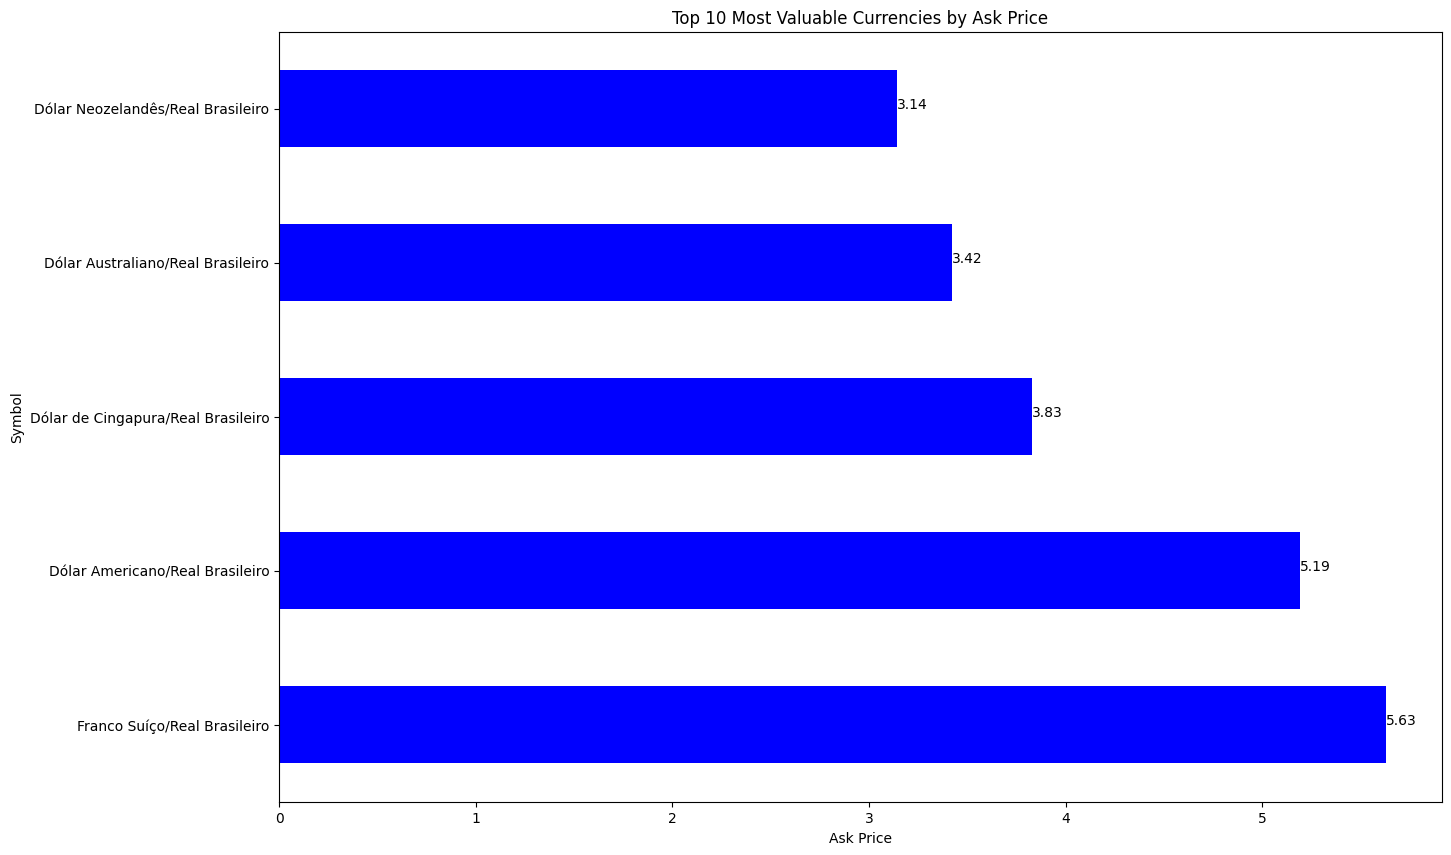

In [8]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        name
        ,round(avg(ask),2) AvgAsk
    FROM df 
    where codein = 'BRL'
    and not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    and ask >=1
    group by name
    order by avg(ask) desc limit 5
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='AvgAsk', ascending=False, inplace=True)

AvgAskByCurrency = newDf.plot(
    kind='barh', x='name', y='AvgAsk', 
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Top 10 Most Valuable Currencies by Ask Price', xlabel='Ask Price', ylabel='Symbol')


# Adicionando rótulos aos dados
for index, value in enumerate(newDf['AvgAsk']):
    plt.text(value, index, str(value))

# Exibir o gráfico
plt.show()

4.4 Average Ask By Day

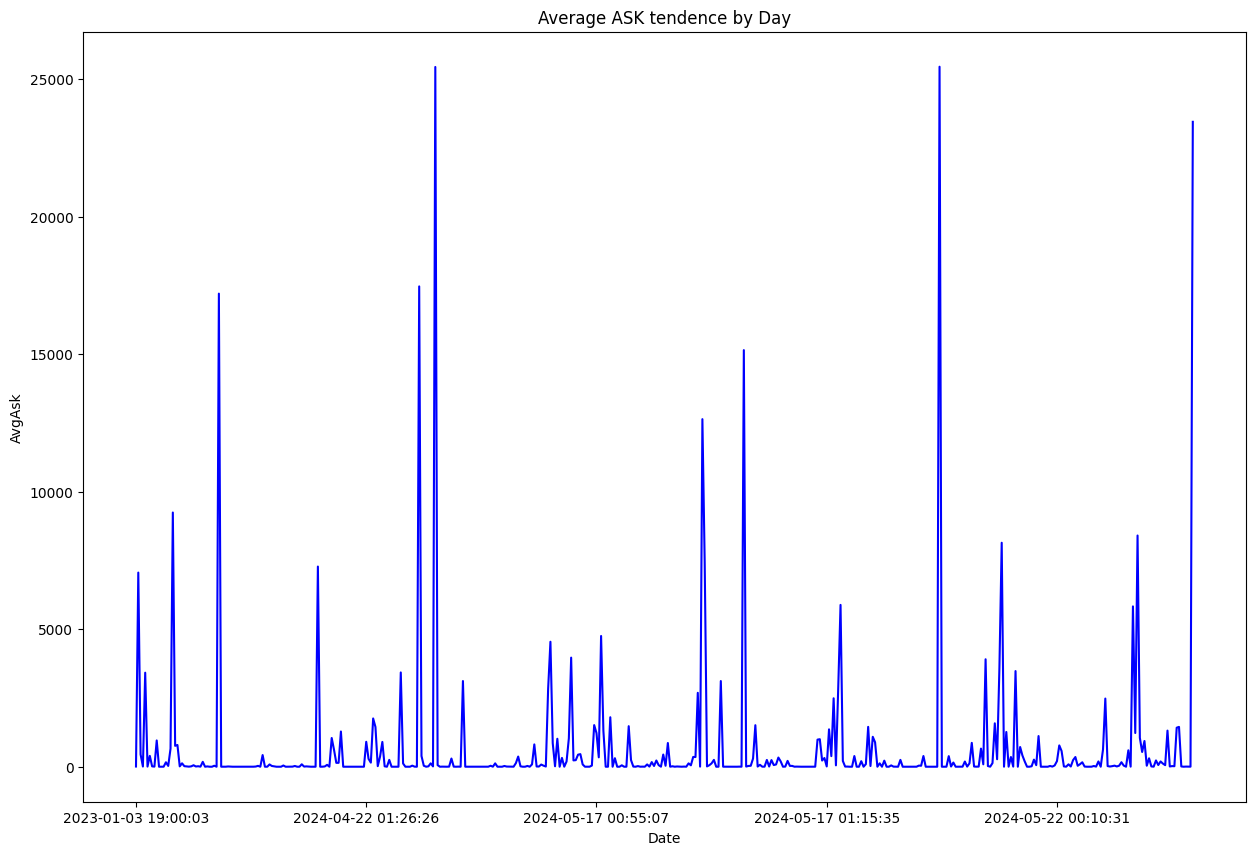

In [9]:

import matplotlib.pyplot as plt

## Query to get the average ASK and BID by day
query = """
    SELECT 
        create_date DT_REF
        ,round(avg(ask),2) AvgAsk
        ,round(avg(bid),2) Avgbid
    FROM df 
    where not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    group by 1
    order by 1 
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='DT_REF', ascending=True, inplace=True)

cht = newDf.plot(
    kind='line', x='DT_REF', y='AvgAsk',
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Average ASK tendence by Day', xlabel='Date', ylabel='AvgAsk')

#exibir o grafico
plt.show()

4.5 Average Bid By Day

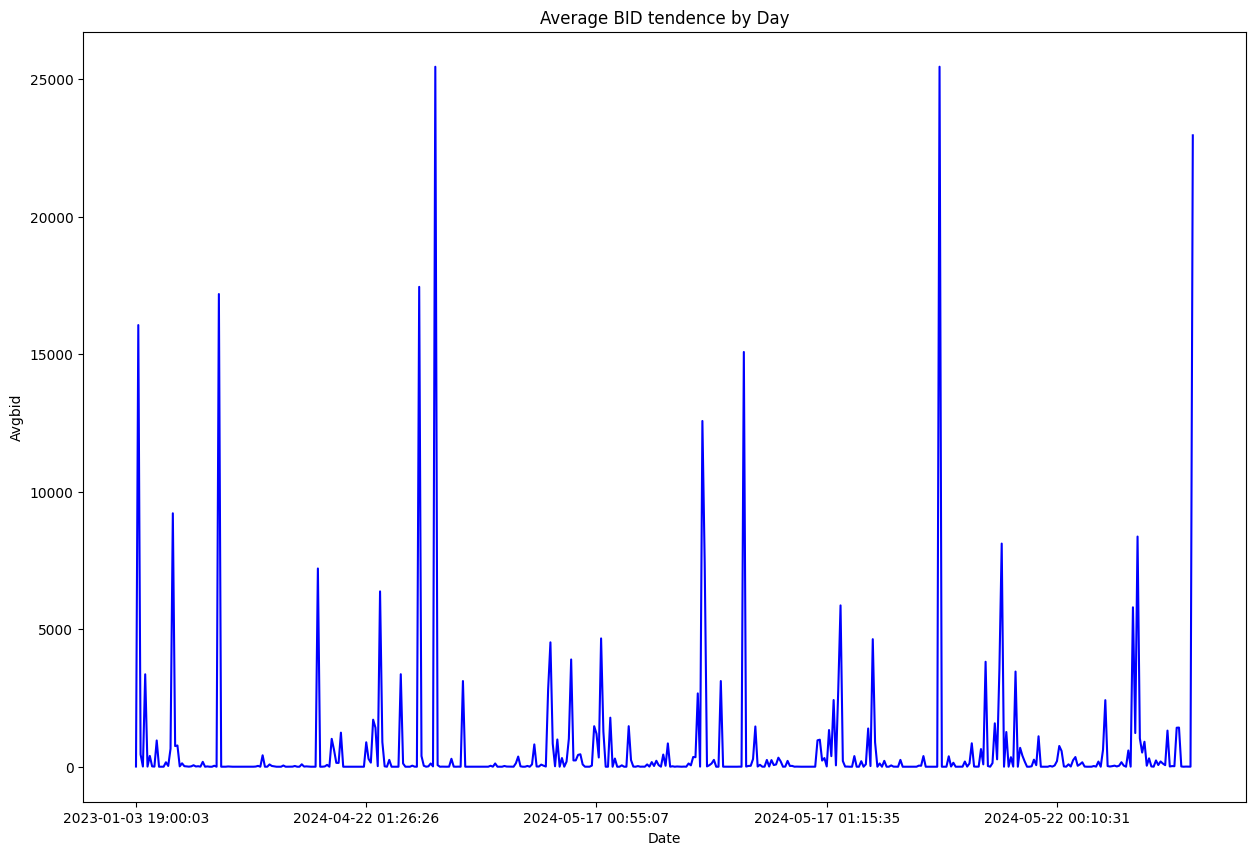

In [10]:

import matplotlib.pyplot as plt

query = """
    SELECT 
        create_date DT_REF
        ,round(avg(ask),2) AvgAsk
        ,round(avg(bid),2) Avgbid
    FROM df 
    where not code in ('BTC', 'ETH', 'LTC', 'DOGE')
    group by 1
    order by 1 
"""

newDf = sqldf(query, locals())
newDf.sort_values(by='DT_REF', ascending=True, inplace=True)

cht = newDf.plot(
    kind='line', x='DT_REF', y='Avgbid',
    figsize=(15, 10), 
    legend=False, 
    color='blue', title='Average BID tendence by Day', xlabel='Date', ylabel='Avgbid')

#exibir o grafico
plt.show()